In [16]:
# Data tools
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from numba import jit 

# Visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Technical analysis
import pandas_ta as ta 
from boruta import BorutaPy

# ML tools
## Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_score
)
random_state = 42

## Hyper params tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, log_loss

## Metrics
# Metrics
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    auc
)

# Adding the script to this notebook
import sys
sys.path.append('/Users/baobach/Algo-Trading-Binance')


plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [17]:
# Load data to the data frame
btc_1min = pd.read_parquet('../data/BTCUSDT_1Min.parq').astype('float')

In [18]:
# Adding feature to compute tick data
def compute_v_dv(df):
    df['v'] = df['volume']
    df['dv'] = df['volume'] * df['close']
    return df

# Adding column for the TickBar function
btc_1min = compute_v_dv(btc_1min)

In [19]:
from tickcomp import TickBar
# Compute the tickbar for every $100M trading value
btc_dollar_bar = TickBar(btc_1min).dollar_tick(100_000_000)
btc_dollar_bar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27884 entries, 2018-01-01 20:36:00 to 2022-12-31 23:35:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    27884 non-null  float64
 1   high    27884 non-null  float64
 2   low     27884 non-null  float64
 3   close   27884 non-null  float64
 4   volume  27884 non-null  float64
 5   v       27884 non-null  float64
 6   dv      27884 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB


In [20]:
# Create 285 teachnical indicators
btc_dollar_bar.ta.strategy()

0it [00:00, ?it/s]/Users/baobach/anaconda3/envs/pythonlab/lib/python3.10/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
131it [00:06, 20.58it/s]


$$
y_t = 
\begin{cases} 
1, & \text{If} \quad p_{t+1} > 1.00025 \times p_t  \\ 
0, & \text{Otherwise}
\end{cases}
$$

In [21]:
# Create the lable for the ML model
btc_dollar_bar['predict'] = np.where(btc_dollar_bar['close'].shift(-1)>1.00025 * btc_dollar_bar['close'],1,0)

# Drop unwanted columns
btc_dollar_bar.drop(['HILOl_13_21', 'HILOs_13_21', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0', 'open',	'high', 'low', 'close', 'volume', 'v', 'dv'], axis=1, inplace=True)

# Drop NaN columns
btc_dollar_bar.dropna(axis=1, inplace=True)

In [22]:
# class frequency
class_freq = btc_dollar_bar['predict'].value_counts()
class_freq

0    14325
1    13559
Name: predict, dtype: int64

In [23]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['predict'])
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}

In [24]:
# check class weights
class_weight = cwts(btc_dollar_bar)
class_weight

{0: 0.97326352530541, 1: 1.0282469208643705}

In [25]:
# Testing the classifier method
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [26]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(btc_dollar_bar.drop('predict',axis=1), btc_dollar_bar['predict'],test_size = 0.30, shuffle=False) 

In [27]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [28]:
# Get the list of remaining features
drop_correlated_features = correlated_features(X_train, threshold=0.9)
X_train_drop = X_train.drop(drop_correlated_features, axis=1)
# Drop cols in test set
X_test_drop = X_test.drop(drop_correlated_features, axis=1)
# Important features for the model
important_feats = X_train_drop.columns

In [29]:
important_feats

Index(['AD', 'AMATe_LR_8_21_2', 'OBV', 'AOBV_LR_2', 'BOP', 'CDL_2CROWS',
       'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE', 'CDL_3OUTSIDE',
       'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS', 'CDL_ABANDONEDBABY',
       'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD', 'CDL_BREAKAWAY',
       'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL', 'CDL_COUNTERATTACK',
       'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1', 'CDL_DOJISTAR',
       'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING', 'CDL_EVENINGDOJISTAR',
       'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE', 'CDL_GRAVESTONEDOJI',
       'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI', 'CDL_HARAMICROSS',
       'CDL_HIGHWAVE', 'CDL_HIKKAKE', 'CDL_HIKKAKEMOD', 'CDL_HOMINGPIGEON',
       'CDL_IDENTICAL3CROWS', 'CDL_INNECK', 'CDL_INSIDE', 'CDL_INVERTEDHAMMER',
       'CDL_KICKING', 'CDL_KICKINGBYLENGTH', 'CDL_LADDERBOTTOM',
       'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MATHOLD',
       'CDL_MORNINGDOJISTAR', 'CDL_MORNINGSTAR', 'CDL_ONNECK', 'CDL_PIERCIN

In [30]:
X_train_drop.describe(include='all')

,AD,AMATe_LR_8_21_2,OBV,AOBV_LR_2,BOP,CDL_2CROWS,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3STARSINSOUTH,CDL_3WHITESOLDIERS,CDL_ABANDONEDBABY,CDL_ADVANCEBLOCK,CDL_BELTHOLD,CDL_BREAKAWAY,CDL_CLOSINGMARUBOZU,CDL_CONCEALBABYSWALL,CDL_COUNTERATTACK,CDL_DARKCLOUDCOVER,CDL_DOJI_10_0.1,CDL_DOJISTAR,CDL_DRAGONFLYDOJI,CDL_ENGULFING,CDL_EVENINGDOJISTAR,CDL_EVENINGSTAR,CDL_GAPSIDESIDEWHITE,CDL_GRAVESTONEDOJI,CDL_HAMMER,CDL_HANGINGMAN,CDL_HARAMI,CDL_HARAMICROSS,CDL_HIGHWAVE,CDL_HIKKAKE,CDL_HIKKAKEMOD,CDL_HOMINGPIGEON,CDL_IDENTICAL3CROWS,CDL_INNECK,CDL_INSIDE,CDL_INVERTEDHAMMER,CDL_KICKING,CDL_KICKINGBYLENGTH,CDL_LADDERBOTTOM,CDL_LONGLINE,CDL_MARUBOZU,CDL_MATCHINGLOW,CDL_MATHOLD,CDL_MORNINGDOJISTAR,CDL_MORNINGSTAR,CDL_ONNECK,CDL_PIERCING,CDL_RICKSHAWMAN,CDL_RISEFALL3METHODS,CDL_SEPARATINGLINES,CDL_SHOOTINGSTAR,CDL_SHORTLINE,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS,LDECAY_5,DEC_1,PSARr_0.02_0.2,PVOL,PVR,SQZ_ON,SQZ_OFF,SQZ_NO,SQZPRO_ON_WIDE,SQZPRO_ON_NARROW,STC_10_12_26_0.5,STCstoch_10_12_26_0.5,SUPERTd_7_3.0,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TTM_TRND_6
count,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.00000,19518.0,19518.000000,19518.0,19518.0,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.00000,19518.000000,19518.000000,19518.000000,1.951800e+04,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000
mean,9348.696036,0.518701,-71024.521694,0.480326,-0.001242,-0.005123,0.0,-0.01537,0.0,0.020494,0.0,0.0,0.010247,0.0,-0.230556,-0.020494,0.809509,0.0,0.035864,-0.046111,14.950302,-0.266421,3.822113,0.051235,-0.081976,-0.343273,-0.020494,3.852854,4.857055,-4.939031,-0.128087,-0.030741,-0.081976,0.276668,0.010247,0.558459,0.0,-0.010247,-0.001281,4.211497,0.035864,0.035864,0.266421,0.502101,0.292038,0.286915,0.0,0.092223,0.276668,-0.143457,0.076852,8.151450,0.0,-0.040988,-5.420637,-0.117840,-0.271544,-0.020494,0.061482,3.909212,-0.005123,-0.199816,-0.061482,0.015370,-0.066605,0.01537,36490.209668,0.495030,0.075776,4.394086e+06,2.503484,0.004048,0.994928,0.001025,0.057332,0.000051,19.720524,17.688293,0.017727,0.922994,0.724459,0.027974
std,11978.082681,0.499663,33383.292388,0.499626,0.582296,0.715785,0.0,7.26459,0.0,7.086058,0.0,0.0,3.920601,0.0,44.523266,1.753232,34.079444,0.0,2.580615,2.146914,35.659274,15.614703,19.173460,10.273577,2.862038,5.849034,3.201102,19.247334,21.497400,21.668712,15.234465,8.469439,29.005363,32.691517,3.036877,7.452305,0.0,1.012246,0.212940,20.085658,3.432683,3.432683,5.154848,38.940652,25.234805,5.348889,0.0,3.035494,5.252774,3.784955,2.771227,27.363063,0.0,3.036618,22.643028,52.925739,38.393043,1.431459,2.478852,19.381912,5.111853,4.465720,6.239922,1.239712,2.580005,1.60051,17432.940965,0.499988,0.264646,7.012573e+06,1.104780,0.063493,0.071041,0.031995,0.232481,0.007158,34.477281,32.267417,0.999868,0.266608,0.446798,0.999634
min,-21954.276537,0.000000,-157966.308936,0.000000,-1.000000,-100.000000,0.0,-100.00000,0.0,-100.000000,0.0,0.0,-100.000000,0.0,-100.000000,-100.000000,-100.000000,0.0,-100.000000,-100.000000,0.000000,-100.000000,0.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,-100.000000,-100.0

In [31]:
minmax = ColumnTransformer([('scaled', MinMaxScaler(), ['AD', 'OBV', 'PVOL', 'LDECAY_5'])],remainder = 'passthrough')
# Fit and transform the data
minmax_cols = minmax.fit_transform(X_train_drop)
# New transfomred data
X_train_dropped_scaled = pd.DataFrame(
    minmax_cols, columns=minmax.get_feature_names_out(),
    index=X_train_drop.index)

In [32]:
X_train_dropped_scaled.describe()

,scaled__AD,scaled__OBV,scaled__PVOL,scaled__LDECAY_5,remainder__AMATe_LR_8_21_2,remainder__AOBV_LR_2,remainder__BOP,remainder__CDL_2CROWS,remainder__CDL_3BLACKCROWS,remainder__CDL_3INSIDE,remainder__CDL_3LINESTRIKE,remainder__CDL_3OUTSIDE,remainder__CDL_3STARSINSOUTH,remainder__CDL_3WHITESOLDIERS,remainder__CDL_ABANDONEDBABY,remainder__CDL_ADVANCEBLOCK,remainder__CDL_BELTHOLD,remainder__CDL_BREAKAWAY,remainder__CDL_CLOSINGMARUBOZU,remainder__CDL_CONCEALBABYSWALL,remainder__CDL_COUNTERATTACK,remainder__CDL_DARKCLOUDCOVER,remainder__CDL_DOJI_10_0.1,remainder__CDL_DOJISTAR,remainder__CDL_DRAGONFLYDOJI,remainder__CDL_ENGULFING,remainder__CDL_EVENINGDOJISTAR,remainder__CDL_EVENINGSTAR,remainder__CDL_GAPSIDESIDEWHITE,remainder__CDL_GRAVESTONEDOJI,remainder__CDL_HAMMER,remainder__CDL_HANGINGMAN,remainder__CDL_HARAMI,remainder__CDL_HARAMICROSS,remainder__CDL_HIGHWAVE,remainder__CDL_HIKKAKE,remainder__CDL_HIKKAKEMOD,remainder__CDL_HOMINGPIGEON,remainder__CDL_IDENTICAL3CROWS,remainder__CDL_INNECK,remainder__CDL_INSIDE,remainder__CDL_INVERTEDHAMMER,remainder__CDL_KICKING,remainder__CDL_KICKINGBYLENGTH,remainder__CDL_LADDERBOTTOM,remainder__CDL_LONGLINE,remainder__CDL_MARUBOZU,remainder__CDL_MATCHINGLOW,remainder__CDL_MATHOLD,remainder__CDL_MORNINGDOJISTAR,remainder__CDL_MORNINGSTAR,remainder__CDL_ONNECK,remainder__CDL_PIERCING,remainder__CDL_RICKSHAWMAN,remainder__CDL_RISEFALL3METHODS,remainder__CDL_SEPARATINGLINES,remainder__CDL_SHOOTINGSTAR,remainder__CDL_SHORTLINE,remainder__CDL_SPINNINGTOP,remainder__CDL_STALLEDPATTERN,remainder__CDL_STICKSANDWICH,remainder__CDL_TAKURI,remainder__CDL_TASUKIGAP,remainder__CDL_THRUSTING,remainder__CDL_TRISTAR,remainder__CDL_UNIQUE3RIVER,remainder__CDL_UPSIDEGAP2CROWS,remainder__CDL_XSIDEGAP3METHODS,remainder__DEC_1,remainder__PSARr_0.02_0.2,remainder__PVR,remainder__SQZ_ON,remainder__SQZ_OFF,remainder__SQZ_NO,remainder__SQZPRO_ON_WIDE,remainder__SQZPRO_ON_NARROW,remainder__STC_10_12_26_0.5,remainder__STCstoch_10_12_26_0.5,remainder__SUPERTd_7_3.0,remainder__THERMOl_20_2_0.5,remainder__THERMOs_20_2_0.5,remainder__TTM_TRND_6
count,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.00000,19518.0,19518.000000,19518.0,19518.0,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.0,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.00000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000,19518.000000
mean,0.609120,0.549682,0.037916,0.508758,0.518701,0.480326,-0.001242,-0.005123,0.0,-0.01537,0.0,0.020494,0.0,0.0,0.010247,0.0,-0.230556,-0.020494,0.809509,0.0,0.035864,-0.046111,14.950302,-0.266421,3.822113,0.051235,-0.081976,-0.343273,-0.020494,3.852854,4.857055,-4.939031,-0.128087,-0.030741,-0.081976,0.276668,0.010247,0.558459,0.0,-0.010247,-0.001281,4.211497,0.035864,0.035864,0.266421,0.502101,0.292038,0.286915,0.0,0.092223,0.276668,-0.143457,0.076852,8.151450,0.0,-0.040988,-5.420637,-0.117840,-0.271544,-0.020494,0.061482,3.909212,-0.005123,-0.199816,-0.061482,0.015370,-0.066605,0.01537,0.495030,0.075776,2.503484,0.004048,0.994928,0.001025,0.057332,0.000051,19.720524,17.688293,0.017727,0.922994,0.724459,0.027974
std,0.233080,0.211063,0.060719,0.266579,0.499663,0.499626,0.582296,0.715785,0.0,7.26459,0.0,7.086058,0.0,0.0,3.920601,0.0,44.523266,1.753232,34.079444,0.0,2.580615,2

In [33]:
def find_columns_with_outliers(dataframe, threshold=1.5):
    """
    Identify columns with outliers in the DataFrame using IQR method.

    Parameters:
    - dataframe: pd.DataFrame
        The input DataFrame.
    - threshold: float, optional
        The threshold for identifying outliers based on IQR.
        Default is set to 1.5.

    Returns:
    - list
        A list of column names with outliers.
    """
    columns_with_outliers = []

    for column in dataframe.columns:
        if dataframe[column].dtype in ['int64', 'float64']:
            Q1 = dataframe[column].quantile(0.25)
            Q3 = dataframe[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]

            if not outliers.empty:
                columns_with_outliers.append(column)

    return columns_with_outliers

In [34]:
outlier_cols = find_columns_with_outliers(X_train_drop)
robust = ColumnTransformer([
        ('cols', RobustScaler(), outlier_cols)
    ],remainder = 'passthrough')

outliers = robust.fit_transform(X_train_drop)

X_train_dropped_scaled = pd.DataFrame(
    outliers, columns=robust.get_feature_names_out(),
    index=X_train_drop.index)

In [35]:
outlier_cols

['CDL_2CROWS',
 'CDL_3INSIDE',
 'CDL_3OUTSIDE',
 'CDL_ABANDONEDBABY',
 'CDL_BELTHOLD',
 'CDL_BREAKAWAY',
 'CDL_CLOSINGMARUBOZU',
 'CDL_COUNTERATTACK',
 'CDL_DARKCLOUDCOVER',
 'CDL_DOJI_10_0.1',
 'CDL_DOJISTAR',
 'CDL_DRAGONFLYDOJI',
 'CDL_ENGULFING',
 'CDL_EVENINGDOJISTAR',
 'CDL_EVENINGSTAR',
 'CDL_GAPSIDESIDEWHITE',
 'CDL_GRAVESTONEDOJI',
 'CDL_HAMMER',
 'CDL_HANGINGMAN',
 'CDL_HARAMI',
 'CDL_HARAMICROSS',
 'CDL_HIGHWAVE',
 'CDL_HIKKAKE',
 'CDL_HIKKAKEMOD',
 'CDL_HOMINGPIGEON',
 'CDL_INNECK',
 'CDL_INSIDE',
 'CDL_INVERTEDHAMMER',
 'CDL_KICKING',
 'CDL_KICKINGBYLENGTH',
 'CDL_LADDERBOTTOM',
 'CDL_LONGLINE',
 'CDL_MARUBOZU',
 'CDL_MATCHINGLOW',
 'CDL_MORNINGDOJISTAR',
 'CDL_MORNINGSTAR',
 'CDL_ONNECK',
 'CDL_PIERCING',
 'CDL_RICKSHAWMAN',
 'CDL_SEPARATINGLINES',
 'CDL_SHOOTINGSTAR',
 'CDL_SHORTLINE',
 'CDL_SPINNINGTOP',
 'CDL_STALLEDPATTERN',
 'CDL_STICKSANDWICH',
 'CDL_TAKURI',
 'CDL_TASUKIGAP',
 'CDL_THRUSTING',
 'CDL_TRISTAR',
 'CDL_UNIQUE3RIVER',
 'CDL_UPSIDEGAP2CROWS',
 'CDL_XSIDE

In [65]:
# Instantiate transformer
preprocessing = ColumnTransformer([
    ('MinMax', MinMaxScaler(), ['AD', 'OBV', 'PVOL', 'LDECAY_5']),
    ('Robust', RobustScaler(), [
        'CDL_2CROWS', 'CDL_3INSIDE', 'CDL_3OUTSIDE', 'CDL_ABANDONEDBABY', 'CDL_BELTHOLD',
        'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER',
        'CDL_DOJI_10_0.1', 'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
        'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE', 'CDL_GRAVESTONEDOJI',
        'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI', 'CDL_HARAMICROSS', 'CDL_HIGHWAVE',
        'CDL_HIKKAKE', 'CDL_HIKKAKEMOD', 'CDL_HOMINGPIGEON', 'CDL_INNECK', 'CDL_INSIDE',
        'CDL_INVERTEDHAMMER', 'CDL_KICKING', 'CDL_KICKINGBYLENGTH', 'CDL_LADDERBOTTOM',
        'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MORNINGDOJISTAR',
        'CDL_MORNINGSTAR', 'CDL_ONNECK', 'CDL_PIERCING', 'CDL_RICKSHAWMAN',
        'CDL_SEPARATINGLINES', 'CDL_SHOOTINGSTAR', 'CDL_SHORTLINE', 'CDL_SPINNINGTOP',
        'CDL_STALLEDPATTERN', 'CDL_STICKSANDWICH', 'CDL_TAKURI', 'CDL_TASUKIGAP',
        'CDL_THRUSTING', 'CDL_TRISTAR', 'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS',
        'CDL_XSIDEGAP3METHODS', 'PSARr_0.02_0.2', 'PVOL', 'SQZ_ON', 'SQZ_OFF', 'SQZ_NO',
        'SQZPRO_ON_WIDE', 'SQZPRO_ON_NARROW', 'STC_10_12_26_0.5', 'STCstoch_10_12_26_0.5',
        'THERMOl_20_2_0.5'
    ])
], remainder='passthrough')


In [66]:
# Fit and transform train set
train_transformed = preprocessing.fit_transform(X_train_drop)
X_train_transformed = pd.DataFrame(
    train_transformed, columns=preprocessing.get_feature_names_out(),
    index=X_train_drop.index)

# Transform test set
test_transformed = preprocessing.transform(X_test_drop)
X_test_transformed = pd.DataFrame(
    test_transformed, columns=preprocessing.get_feature_names_out(),
    index=X_test_drop.index)

---

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Build a base model
base_model = RandomForestClassifier(max_depth = 5, class_weight=class_weight, random_state=random_state)
base_model.fit(X_train_transformed,y_train)
print (classification_report(y_train[-252:], base_model.predict(X_train_transformed[-252:])))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       155
           1       0.65      0.25      0.36        97

    accuracy                           0.66       252
   macro avg       0.65      0.58      0.56       252
weighted avg       0.66      0.66      0.61       252



In [67]:
# Create a DMatrix for training
dtrain = xgb.DMatrix(X_train_transformed, label=y_train)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',         # Logarithmic loss
    'max_depth': 3,                   # Maximum depth of a tree
    'eta': 0.1,                       # Learning rate
    'subsample': 0.8,                 # Subsample ratio of the training instances
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 42                         # Random seed for reproducibility
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

In [69]:
# Create a DMatrix for testing
dtest = xgb.DMatrix(X_test_transformed)

# Make predictions
predictions = model.predict(dtest)

# If it's a binary classification problem, you might want to round the predictions
predictions_binary = [round(pred) for pred in predictions]

In [70]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions_binary)
conf_matrix = confusion_matrix(y_test, predictions_binary)
class_report = classification_report(y_test, predictions_binary)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.5285680133875209
Confusion Matrix:
[[4139  278]
 [3666  283]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.94      0.68      4417
           1       0.50      0.07      0.13      3949

    accuracy                           0.53      8366
   macro avg       0.52      0.50      0.40      8366
weighted avg       0.52      0.53      0.42      8366



In [77]:
# Create a DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the hyperparameter space
param_space = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'min_child_weight': [1, 3, 5, 7, 9, 11, 13]
}

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=random_state)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_space,
    n_iter=200,
    scoring=make_scorer(log_loss, greater_is_better=False),
    cv=5,  
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=random_state
)

# Perform the random search
random_search.fit(X_train_transformed, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_transformed)
test_log_loss = log_loss(y_test, y_pred_proba)
print(f'Test Log Loss with Best Model: {test_log_loss}')


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters: {'subsample': 0.6, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.6}
Test Log Loss with Best Model: 0.7545779711590689


In [78]:
# Evaluate the model
accuracy = accuracy_score(y_test, best_model.predict(X_test_transformed))
conf_matrix = confusion_matrix(y_test, best_model.predict(X_test_transformed))
class_report = classification_report(y_test, best_model.predict(X_test_transformed))

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.508247669136983
Confusion Matrix:
[[2629 1788]
 [2326 1623]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56      4417
           1       0.48      0.41      0.44      3949

    accuracy                           0.51      8366
   macro avg       0.50      0.50      0.50      8366
weighted avg       0.50      0.51      0.50      8366



In [81]:
final_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=random_state, **random_search.best_params_)
final_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [82]:
# Predicting the test dataset
y_pred = final_model.predict(X_test_transformed)
# Measure Accuracy
acc_train = accuracy_score(y_train, final_model.predict(X_train_transformed))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.6857 
 Test Accuracy 		: 0.5082


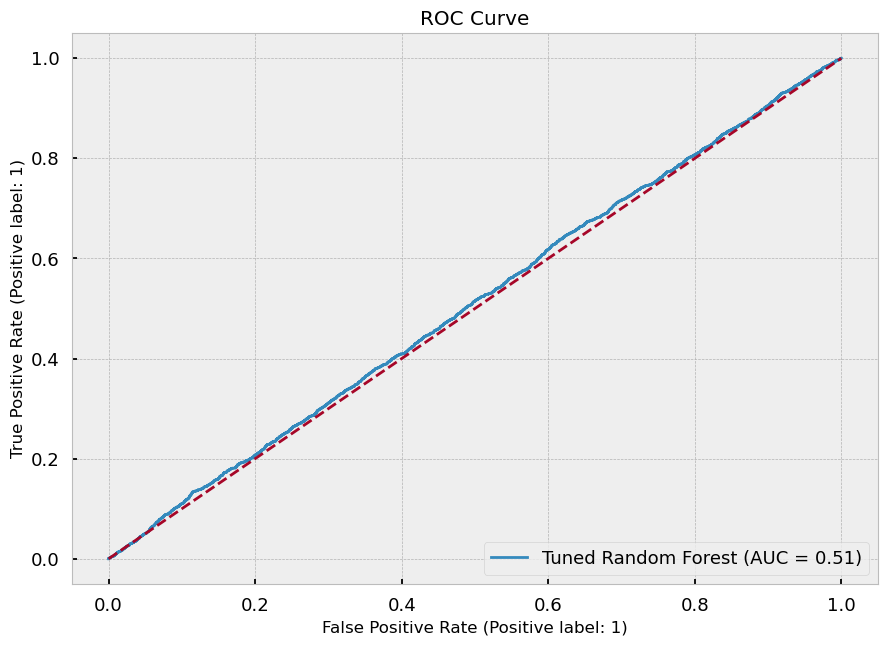

In [85]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(
        final_model,
        X_test_transformed,
        y_test,
        name='Tuned Random Forest')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

In [86]:
# Saving final model
from joblib import dump, load
dump(final_model, '../models/final_model.joblib')

['../models/final_model.joblib']